# Wstęp do matematyki finansowej 
## Laboratorium 2.

In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt

### Zadanie 2.a
Wygeneruj trajektorię procesu Poissona z zadaną intensywnością $\lambda > 0$.

**Rozwiązanie oparte na konstruktywnej definicji procesu Poissona:**

In [27]:
def PoissProc(lamb, T):
    
    # exponentially distributed times between events
    interarrival_times = [0]
    
    while True:
        xi = np.random.exponential(lamb)
        if sum(interarrival_times) + xi >= T:
            break
        else:
            interarrival_times.append(xi)
        
    # moments of subsequent events
    events_moments = np.array(interarrival_times).cumsum() 
    
    # time-event pairs creation
    events = pd.DataFrame(np.ones(len(events_moments)), index = events_moments)
    events[0] = events[0].cumsum() - 1  
    return events

In [28]:
PoissProc(0.5, 2)

,0
0.000000,0.0
0.093073,1.0
0.525776,2.0
0.928176,3.0
1.074387,4.0
1.303372,5.0
1.761519,6.0


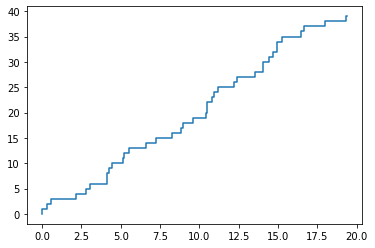

In [30]:
lamb = 0.5

poiss = PoissProc(0.5, 20)
x_axis = np.insert(np.array(poiss.index), 0, 0, axis=0)
y_axis = np.insert(np.array(poiss), 0, 0, axis=0)

plt.step(x_axis, y_axis, label="Lambda = %d"%lamb)

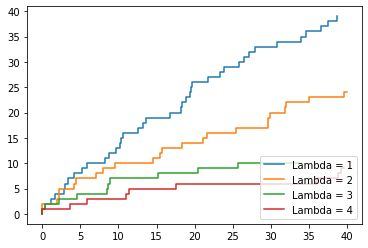

In [33]:
lambdas = [1, 2, 3, 4]

X_T = [[PoissProc(lam, 40)] for lam in lambdas]

# rysowanie od momentu pierwszego zgłoszenia
graphs = [plt.step(np.insert(np.array(X_T[i][0].index), 0, 0, axis=0), np.insert(np.array(X_T[i][0]), 0, 0, axis=0), label="Lambda = %d"%lambdas[i])[0] for i in range(len(lambdas))]
plt.legend(handles=graphs, loc=4)

### Zadanie 2.b
Wygeneruj trajektorię procesu Wienera korzystając z dwóch pierwszych metod. Zaimplementuj zaprezentowaną dekompozycję Cholesky’ego. Porównaj czasy obu metod.

In [5]:
def Wiener_I(T = 1.0, N = 1e5):
    # Process parameters
    N = int(N)
    dt = T/N # time increment value (constant)
    
    # Initial values
    W = [0] * N
    dW = [0] * N
    
    # Steps of the Brownian motion computation
    for t in range(1, N):
        dW[t] = np.sqrt(dt) * float(np.random.standard_normal(size=1)) # => dW ~ N(0, dt)
        W[t] = W[t-1] + dW[t]
    return W

--- Execution time: 0.008121013641357422 ---


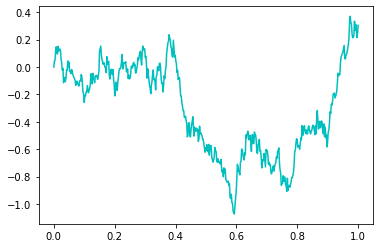

In [6]:
start_time = time.time()
wiener = Wiener_I(N = 500)
exec_time1 = time.time() - start_time
print("--- Execution time: %s ---" % (exec_time1))

plt.plot(np.linspace(0, 1, len(wiener)), wiener, 'c')

In [7]:
def Wiener_II(T = 1.0, N = 500, builtIn = True):
    
    def cholesky(S):
        # An assertion that given matrix is positive definite
        assert(np.all(np.linalg.eigvals(S) > 0))
        
        n = len(S)
        L = [[0.0] * n for i in range(n)]
        for i in range(n):
            for k in range(i+1):
                tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
                if (i == k):
                    L[i][k] = math.sqrt(S[i][i] - tmp_sum)
                else:
                    L[i][k] = (1.0 / L[k][k] * (S[i][k] - tmp_sum))
        return L

    N = int(N)
    dt = T/N
    
    # covariance matrix
    t_seq = np.linspace(dt, T, N)
    S = [[min(x, y) for x in t_seq] for y in t_seq]
    if builtIn:
        A = np.linalg.cholesky(S)
    else:
        A = np.array(cholesky(S))
    X = np.random.normal(loc = 0, scale = 1, size = N)
    W = A.dot(X)
    
    return W

--- Execution time: 16.118558168411255 ---


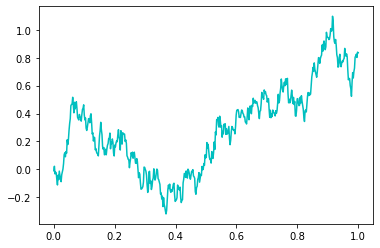

In [8]:
start_time = time.time()
wiener = Wiener_II(builtIn = False)
exec_time2 = time.time() - start_time
print("--- Execution time: %s ---" % (exec_time2))

plt.plot(np.linspace(0, 1, len(wiener)), wiener, 'c')

--- Execution time: 0.23400020599365234 ---


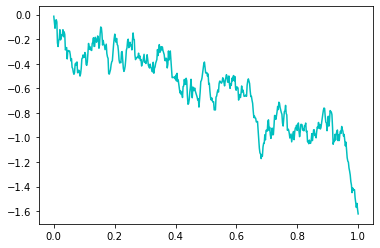

In [9]:
start_time = time.time()
wiener = Wiener_II()
exec_time3 = time.time() - start_time
print("--- Execution time: %s ---" % (exec_time3))

plt.plot(np.linspace(0, 1, len(wiener)), wiener, 'c')
# built-in Cholesky decomposition function performs much quicker than given implementation

### Porównanie czasów działania implementacji obydwu metod dla $N = 500$

In [10]:
df = pd.DataFrame({'Wiener_I': [exec_time1], 'Wiener_II': [exec_time2], 'Wiener_II (+ built-in)': [exec_time3]})
print(df.to_string(index=False))

 Wiener_I  Wiener_II  Wiener_II (+ built-in)
 0.008121  16.118558                   0.234


### Porównanie czasów działania implementacji obydwu metod dla różnych wartości prarametru $N$

In [11]:
def exec_times(N_max, method):
    N_rng = [i for i in range(100, int(N_max+1), 50)]
    times = []
    for N in N_rng:
        start_time = time.time()
        wiener = method(N = N)
        times.append(time.time() - start_time)
    return (N_rng, times)

In [12]:
N_rng, exec_times_I = exec_times(N_max = 1e3, method = Wiener_I)

In [13]:
N_rng, exec_times_II = exec_times(N_max = 1e3, method = Wiener_II) 

In [14]:
exec_times_III = []
for N in N_rng:
    start_time = time.time()
    wiener = Wiener_II(N = N, builtIn=False)
    exec_times_III.append(time.time() - start_time)

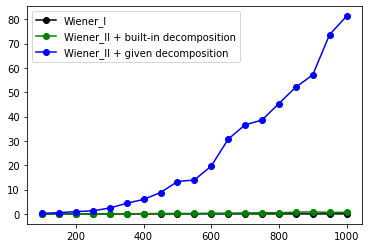

In [15]:
plt.plot(N_rng, exec_times_I, '-ko', label="Wiener_I")
plt.plot(N_rng, exec_times_II, '-go', label="Wiener_II + built-in decomposition")
plt.plot(N_rng, exec_times_III, '-bo', label="Wiener_II + given decomposition")
plt.legend()
plt.show()

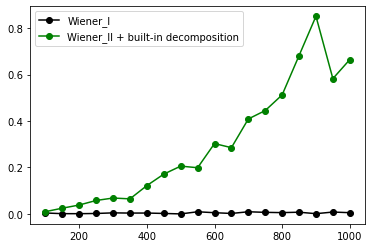

In [16]:
plt.plot(N_rng, exec_times_I, '-ko', label="Wiener_I")
plt.plot(N_rng, exec_times_II, '-go', label="Wiener_II + built-in decomposition")
plt.legend()
plt.show()

### Zadanie 2.c
Wygeneruj i zwizualizuj trajektorię dwuwymiarowego procesu Wienera $W_{t} = (W_{t}^{(1)}, W_{t}^{(2)})$ o składowych niezależnych.

In [17]:
def Wiener_ind(T = 1.0, N = 1e5):
    # Process parameters
    N = int(N)
    dt = T/N
    
    W1 = Wiener_I(T, N)
    W2 = Wiener_I(T, N)

    fig, ax = plt.subplots()
    ax.plot(W1, W2)
    ax.set_xlabel('W1')
    ax.set_ylabel('W2')
    ax.set_title('2-dimensional Wiener process path')
    plt.tight_layout()
    plt.show()

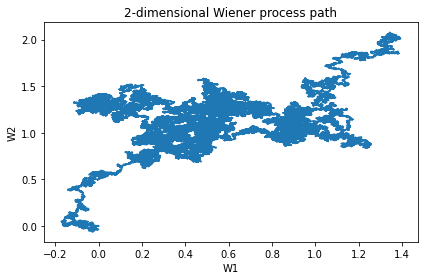

In [18]:
Wiener_ind()

### Zadanie 2.d 
Wygeneruj i zwizualizuj trajektorię dwuwymiarowego procesu Wienera $W_{t} = (W_{t}^{(1)}, W_{t}^{(2)})$ o składowych zależnych takich, że dla każdego $t>0$, $Cor(W_{t}^{(1)}, W_{t}^{(2)}) = \rho$, gdzie $\rho \in [-1, 1]$ jest ustaloną liczbą

In [19]:
def Wiener_dep(T = 1.0, N = 1e5, rho = 0.8):
    # Process parameters
    N = int(N)
    dt = T/N
    
    W1 = Wiener_I(T, N)
    W2 = Wiener_I(T, N)
    
    # V1 = W1
    V2 = rho * np.array(W1) + np.sqrt(1 - rho **2) * np.array(W2)

    fig, ax = plt.subplots()
    ax.plot(W1, V2)
    ax.set_xlabel('W1(t)')
    ax.set_ylabel('W2(t)')
    ax.set_title('2-dimensional Wiener process path')
    plt.tight_layout()
    plt.show()

rho =  -1.0


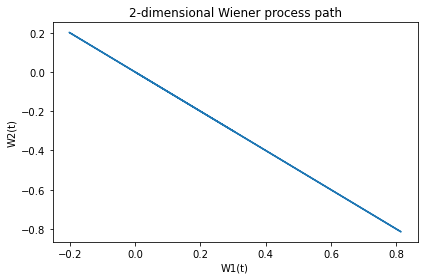

rho =  -0.75


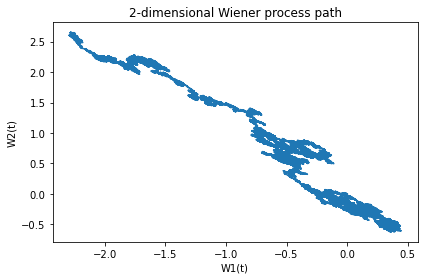

rho =  -0.5


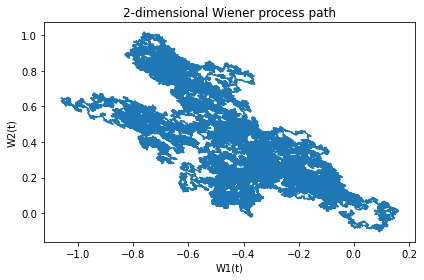

rho =  -0.25


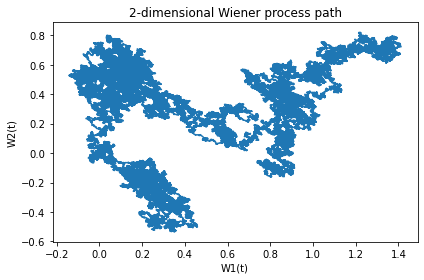

rho =  0.0


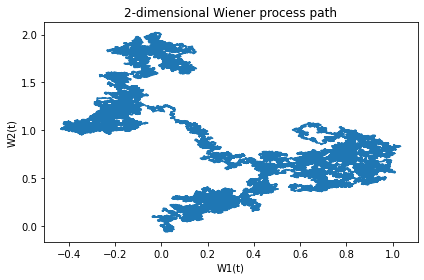

rho =  0.25


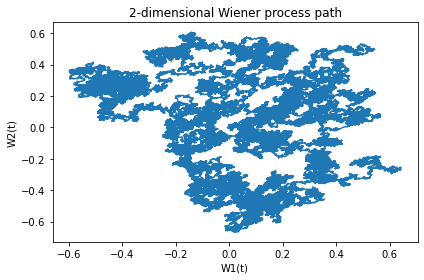

rho =  0.5


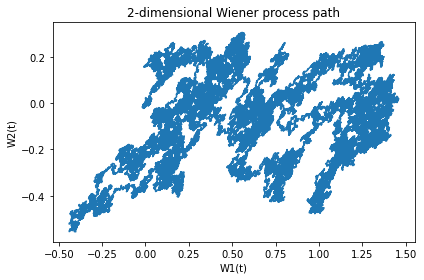

rho =  0.75


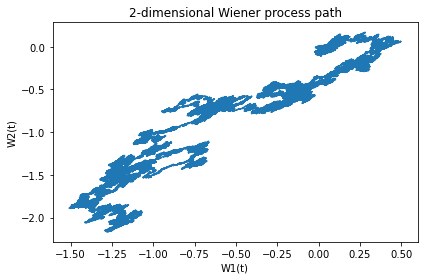

rho =  1.0


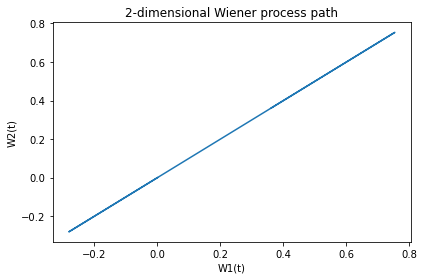

In [20]:
rho_rng = np.linspace(start=-1, stop=1, num=9)
for rho in rho_rng:
    print('rho = ', rho)
    Wiener_dep(rho = rho)

### Zadanie 2.e
Spróbuj zaobserwować różnicę w zbieżności z prawdopodobieństwem1, według prawdopodobieństwa orazbrakiem zbieżności na przykładzie Mocnego i Słabego Prawa Wielkich Liczb.

In [21]:
# Given probabilities
def prob_I(n):
    return 1/(2*(n+1)**(3/2))
def prob_II(n):
    return 1/(2*(n+1)*math.log(n+1))
def prob_III(n):
    return 1/(2*(n+1))

In [22]:
def generator(prob_fun, N = 1e3):
    X = []
    means = [0]
    # startuje od 0 ze wzgl na log w spwl
    for n in range(1, int(N)):
        opt = [-(n+1), 0, (n+1)]
        p = prob_fun(n)
        prob = [p, 1-2*p, p]
        X.append(int(np.random.choice(opt, 1, p=prob)))
        means.append(sum(X)/len(X))
    return(X, means)

def simulate(prob_fun):
    for i in range(30):
        X, means = generator(prob_fun, N = 5e4)
        plt.plot(means)

    eps = 0.5
    plt.axhline(y=eps, linestyle='-', linewidth = 3.0)
    plt.axhline(y=-eps, linestyle='-', linewidth = 3.0)
    plt.show()

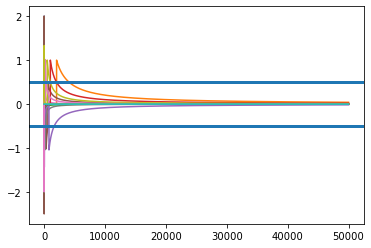

In [23]:
# Strong law of large numbers simulation
simulate(prob_I)

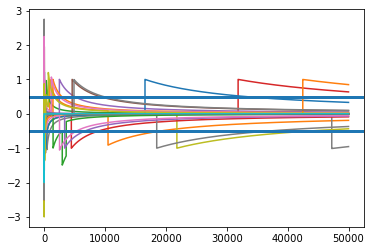

In [24]:
# Weak law of large numbers simulation
simulate(prob_II)

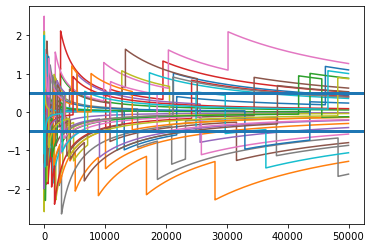

In [25]:
# Divergence 
simulate(prob_III)

### Zadanie 2.f

Spróbuj zweryfikować empirycznie prawdziwość Prawa Iterowanego Logarytmu. W tym celu wygeneruj dużo trajektorii $(W_{t})_{t \in [0,1]}$ dla dużego $T$ oraz narysuj je razem z funkcjami $f_{\pm}(t)= \pm \sqrt{2t\log \log t}$. Być może dobrze będzie rozważyć skalę logarytmiczną na osi odciętych.

In [26]:
def f(t):
    return np.sqrt(2*t*np.log(np.log(t)))

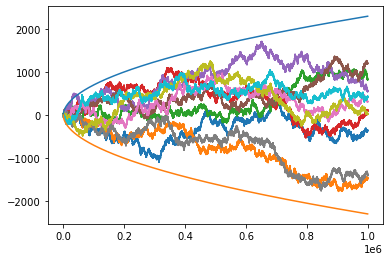

In [27]:
for i in range(10):
    tmax = int(1e6)
    t_rng = np.linspace(0, tmax, tmax)
    wiener = Wiener_I(T = tmax, N = tmax)
    plt.plot(t_rng, wiener)
    
t_rng = t_rng[t_rng >= math.e]
plt.plot(t_rng, f(t_rng))
plt.plot(t_rng, -f(t_rng))

(10000, 1000000.0)

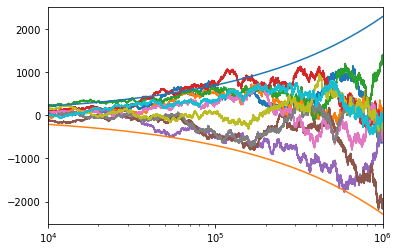

In [28]:
# skala logarytmiczna

for i in range(10):
    tmax = int(1e6)
    t_rng = np.linspace(0, tmax, tmax)
    wiener = Wiener_I(T = tmax, N = tmax)
    plt.plot(t_rng, wiener)
    
t_rng = t_rng[t_rng >= math.e]
plt.plot(t_rng, f(t_rng))
plt.plot(t_rng, -f(t_rng))
plt.xscale('log')
plt.xlim([int(1e4), max(t_rng)])